# exp030

In [1]:
import os
import sys
import itertools
import datetime
from dateutil.relativedelta import relativedelta
from dotenv import load_dotenv
load_dotenv()
sys.path.append(os.getenv('UTILS_PATH'))

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

import line_notify

In [2]:
import builtins
import types

def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val

            # functions / callables
        if hasattr(val, '__call__'):
            yield name, val


def noglobal(f):
    '''
    ref: https://gist.github.com/raven38/4e4c3c7a179283c441f575d6e375510c
    '''
    return types.FunctionType(f.__code__,
                              dict(imports()),
                              f.__name__,
                              f.__defaults__,
                              f.__closure__
                              )

In [3]:
SEED = 42

ディレクトリ設定

In [4]:
INPUT_DIR = os.getenv('INPUT_DIR')
OUTPUT_DIR = os.getenv('OUTPUT_DIR')
#exp_name = os.path.dirname(__file__).split('/')[-1]
exp_name = 'exp030'
os.makedirs(OUTPUT_DIR + exp_name, exist_ok=True)

データ読み込み

In [5]:
articles = pd.read_csv(INPUT_DIR + 'articles.csv', dtype='object')
customers = pd.read_csv(INPUT_DIR + 'customers.csv')
transactions = pd.read_csv(INPUT_DIR + 'transactions_train.csv', dtype={'article_id':'str'}, parse_dates=['t_dat'])
sample = pd.read_csv(INPUT_DIR + 'sample_submission.csv')

# 前処理

In [6]:
# 名寄せ
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].str.replace('None','NONE')
# transactionに紐づけ
transactions = transactions.merge(customers, on='customer_id', how='left')
transactions = transactions.merge(articles, on='article_id', how='left')

In [7]:
# label_encoding
le_cols = ['product_type_name', 'product_group_name', 'graphical_appearance_name',
            'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name',
            'index_name', 'index_group_name', 'section_name', 'garment_group_name']
for c in le_cols:
    le = LabelEncoder()
    articles[c] = le.fit_transform(articles[c].fillna(''))


le_cols = ['club_member_status', 'fashion_news_frequency', 'postal_code']
for c in le_cols:
    le = LabelEncoder()
    customers[c] = le.fit_transform(customers[c].fillna(''))

# データセット作成（レコメンド→対象データセット作成→特徴量エンジニアリング）

In [8]:
@noglobal
def get_customer_frequent(history, n=12, timedelta=None):
    """顧客ごと商品の購入数をカウントし上位の商品を抽出

    Args:
        history (dataframe): 集計対象の実績データ
        n (int): レコメンド対象とする数
        timedelta (dateutil.relativedelta): 指定された場合、実績データの終端からtimedelta分のデータを取得する

    Returns:
        dataframe: 抽出結果
    """
    if timedelta is not None:
        st_date = history['t_dat'].max() - timedelta
        history = history[history['t_dat']>=st_date].copy()
        
    customer_agg = history.groupby(['customer_id', 'article_id'])['t_dat'].count().reset_index()
    customer_agg = customer_agg.rename(columns={'t_dat':'cnt'})
    customer_agg = customer_agg.sort_values(['customer_id', 'cnt'], ascending=False)
    result = customer_agg.groupby('customer_id').head(n)
    return result[['customer_id', 'article_id']]

@noglobal
def get_popular_article(history, n=12, timedelta=None):
    """全体の購入数をカウントし上位の商品を抽出

    Args:
        history (dataframe): 集計対象の実績データ
        n (int): レコメンド対象とする数
        timedelta (dateutil.relativedelta): 指定された場合、実績データの終端からtimedelta分のデータを取得する

    Returns:
        list: 抽出結果
    """
    # 全体の購入数量
    if timedelta is not None:
        st_date = history['t_dat'].max() - timedelta
        history = history[history['t_dat']>=st_date].copy()

    total_agg = history.groupby('article_id')['t_dat'].count().reset_index()
    total_agg = total_agg.rename(columns={'t_dat':'cnt'})
    total_agg = total_agg.sort_values(['cnt'], ascending=False)
    total_agg = total_agg.head(n)
    result = list(total_agg['article_id'].values)
    return result

@noglobal
def get_reccomend(target_customer_id, history):
    """対象のcustomer_idに対するレコメンド結果を返す

    Args:
        target_customer_id (list): 対象のcustomer_id
        history (dataframe): レコメンドに用いる実績データ

    Returns:
        dataframe: レコメンド結果
    """
    n = 12
    result = pd.DataFrame()
    
    for td in [None, relativedelta(weeks=1), relativedelta(months=1), relativedelta(years=1)]:

        customer_freq = get_customer_frequent(history, n, td)
        popular_article = get_popular_article(history, n, td)
        # customerとpopular articleの全組み合わせでdataframe作成
        popular_article = pd.DataFrame(itertools.product(target_customer_id, popular_article), columns=['customer_id', 'article_id'])
        tmp = pd.concat([customer_freq, popular_article])
        result = result.append(tmp)
    result = result.drop_duplicates()
    result = result[result['customer_id'].isin(target_customer_id)].copy()

    return result

In [9]:
@noglobal
def add_labels(recom_result, history):
    """レコメンドしたデータが学習期間で購入されたかどうかのフラグを付与する

    Args:
        recom_result (_type_): レコメンド結果
        train_tran (_type_): 学習期間のトランザクションデータ

    Returns:
        _type_: 学習期間での購入フラグを付与したレコメンド結果
    """
    history = history[['customer_id', 'article_id']].drop_duplicates()
    history['buy'] = 1
    recom_result = recom_result.merge(history, on=['customer_id', 'article_id'], how='left')
    recom_result['buy'] = recom_result['buy'].fillna(0)
    return recom_result


In [10]:
@noglobal
def make_article_features(articles):
    cols = ['product_type_name', 'product_group_name', 'graphical_appearance_name',
            'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name',
            'index_name', 'index_group_name', 'section_name', 'garment_group_name']
    return articles[['article_id']+cols]

@noglobal
def make_article_tran_features(history):
    df = history.groupby('article_id').agg({'t_dat':['count', 'max', 'min'],
                                            'price':['max', 'min', 'mean'], 
                                            'age':['max', 'min', 'mean', 'std']}).reset_index()
    df.columns = ['article_id','article_total_cnt', 'article_total_latest_buy', 'article_total_1st_buy', 'article_price_max', 'article_price_min', 'article_price_mean', 'article_age_max', 'article_age_min', 'article_age_mean', 'article_age_std']
    df['article_total_1st_buy'] = (history['t_dat'].max() - df['article_total_1st_buy']).dt.days
    df['article_total_latest_buy'] = (history['t_dat'].max() - df['article_total_latest_buy']).dt.days
    return df


@noglobal
def make_customer_features(customers):
    return customers

@noglobal
def make_customer_tran_features(history):
    df = history.groupby('customer_id').agg({'t_dat':['count', 'max', 'min'],
                                            'price':['max', 'min', 'mean']}).reset_index()
    df.columns = ['customer_id','customer_total_cnt', 'customer_total_latest_buy', 'customer_total_1st_buy', 'customer_price_max', 'customer_price_min', 'customer_price_mean']
    df['customer_total_1st_buy'] = (history['t_dat'].max() - df['customer_total_1st_buy']).dt.days
    df['customer_total_latest_buy'] = (history['t_dat'].max() - df['customer_total_latest_buy']).dt.days
    return df

@noglobal
def make_customer_article_features(target, history):
    df = target.merge(history, on=['customer_id', 'article_id'], how='inner')
    df = df.groupby(['customer_id', 'article_id']).agg({'t_dat':['count', 'min', 'max']}).reset_index()
    df.columns = ['customer_id', 'article_id', 'count', '1st_buy_date_diff', 'latest_buy_date_diff']
    df['1st_buy_date_diff'] = (history['t_dat'].max() - df['1st_buy_date_diff']).dt.days
    df['latest_buy_date_diff'] = (history['t_dat'].max() - df['latest_buy_date_diff']).dt.days
    return df

@noglobal
def add_features(df, history, articles, customers):
    article_features = make_article_features(articles)
    article_tran_features = make_article_tran_features(history)
    customer_features = make_customer_features(customers)
    customer_tran_features = make_customer_tran_features(history)
    customer_article_features = make_customer_article_features(df[['customer_id', 'article_id']], history)

    df = df.merge(article_features, on=['article_id'], how='left')
    df = df.merge(article_tran_features, on=['article_id'], how='left')
    df = df.merge(customer_features, on=['customer_id'], how='left')
    df = df.merge(customer_tran_features, on=['customer_id'], how='left')
    df = df.merge(customer_article_features, on=['article_id', 'customer_id'], how='left')
    return df
    

In [11]:
# テストデータの作成
target_id = sample['customer_id'].tolist()
recom = get_reccomend(target_id, transactions)
ml_test = add_features(recom, transactions, articles, customers)

# レコメンド商品を購入するかどうかの2値分類モデル

In [12]:
def apk(y_true, y_pred, K=12):
    assert(len(y_true) == len(y_pred))
    apks = []
    for idx in range(len(y_true)):
        y_i_true = y_true[idx]
        y_i_pred = y_pred[idx]

        # 予測値の数と重複の確認
        assert(len(y_i_pred) <= K)
        assert(len(np.unique(y_i_pred)) == len(y_i_pred))

        sum_precision = 0.0
        num_hits = 0.0

        for i, p in enumerate(y_i_pred):
            if p in y_i_true:
                num_hits += 1
                precision = num_hits / (i+1)
                sum_precision += precision
        apk = sum_precision / min(len(y_i_true), K)
        apks.append(apk)
    return apks

In [13]:
target = 'buy'
not_use_cols = ['customer_id', 'article_id', target]
features = [c for c in ml_test.columns if c not in not_use_cols]

In [14]:
params = {
    "objective": "binary",
    "boosting" : "gbdt",
    "learning_rate": 0.01,
    "metric": "binary_logloss",
    "seed": SEED
}

In [15]:
# 1週ずつローリングして学習データを生成し検証
n_iter = 3
train_start = datetime.datetime(2020,9,9)
valid_start = datetime.datetime(2020,9,16)
valid_end = datetime.datetime(2020,9,22)
test_pred = np.zeros(len(ml_test))
fi = pd.DataFrame()
scores = []
for i in range(n_iter):
    # 学習データの作成
    history_tran = transactions[transactions['t_dat'] < train_start].copy()
    target_tran = transactions[(transactions['t_dat'] >= train_start) & (transactions['t_dat'] < valid_start)].copy()
    target_id = target_tran['customer_id'].unique().tolist()
    recom = get_reccomend(target_id, history_tran)
    ml_train = add_labels(recom, target_tran)
    ml_train = add_features(ml_train, history_tran, articles, customers)

    # 評価データの作成
    history_tran = transactions[transactions['t_dat'] < valid_start].copy()
    target_tran = transactions[(transactions['t_dat'] >= valid_start) & (transactions['t_dat'] <= valid_end)].copy()
    target_id = target_tran['customer_id'].unique().tolist()
    recom = get_reccomend(target_id, history_tran)
    ml_valid = add_labels(recom, target_tran)
    ml_valid = add_features(ml_valid, history_tran, articles, customers)
    
    # 学習
    tr_x, tr_y = ml_train[features], ml_train[target]
    vl_x, vl_y = ml_valid[features], ml_valid[target]
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)
    model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                    num_boost_round=20000, early_stopping_rounds=100,verbose_eval=1000)

    # 特徴量重要度
    fi_tmp = pd.DataFrame()
    fi_tmp['iter'] = n_iter
    fi_tmp['feature'] = model.feature_name()
    fi_tmp['importance'] = model.feature_importance(importance_type='gain')
    fi = fi.append(fi_tmp)

    # cv
    vl_pred = model.predict(vl_x, num_iteration=model.best_iteration)
    # 正解データ作成
    valid = transactions[(transactions['t_dat'] >= valid_start) & (transactions['t_dat'] <= valid_end)].copy()
    valid = valid[['customer_id', 'article_id']].drop_duplicates()
    valid = valid.groupby('customer_id')['article_id'].apply(list).reset_index()
    valid = valid.sort_values('customer_id').reset_index(drop=True)
    # 2値分類の出力を元に12個選定
    valid_pred = ml_valid[['customer_id', 'article_id']].copy()
    valid_pred['prob'] = vl_pred
    valid_pred = valid_pred.sort_values(['customer_id', 'prob'], ascending=False)
    valid_pred = valid_pred.groupby('customer_id').head(12)
    valid_pred = valid_pred.groupby('customer_id')['article_id'].apply(list).reset_index()
    valid_pred = valid_pred.sort_values('customer_id').reset_index(drop=True)
    assert(valid['customer_id'].tolist() == valid_pred['customer_id'].tolist())
    # MAP@12
    score = np.mean(apk(valid['article_id'].tolist(), valid_pred['article_id'].tolist()))
    print(f'{valid_start.strftime("%Y-%m-%d")} - {valid_end.strftime("%Y-%m-%d")} : ' + '{:.5f}'.format(score))
    scores.append(score)

    ml_valid['pred'] = vl_pred
    ml_valid.to_csv(OUTPUT_DIR + f'{exp_name}/{exp_name}_oof{i}.csv', index=False)
    
    test_pred += model.predict(ml_test[features], num_iteration=model.best_iteration) / n_iter

    train_start = train_start - relativedelta(days=7)
    valid_start = valid_start - relativedelta(days=7)
    valid_end = valid_end - relativedelta(days=7)
cv_score = np.mean(scores)
print(f'MAP@12 : ' + '{:.5f}'.format(cv_score))

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 12998, number of negative: 2977593
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4882
[LightGBM] [Info] Number of data points in the train set: 2990591, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004346 -> initscore=-5.434075
[LightGBM] [Info] Start training from score -5.434075
Training until validation scores don't improve for 100 rounds
[1000]	training's binary_logloss: 0.0215607	valid_1's binary_logloss: 0.0245037
Early stopping, best iteration is:
[1080]	training's binary_logloss: 0.0214579	valid_1's binary_logloss: 0.0244979
2020-09-16 - 2020-09-22 : 0.03021
[LightGBM] [Info] Number of positive: 14882, number of negative: 3352651
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhe

In [16]:
scores

[0.030210162359026686, 0.03041539045191607, 0.029391949248490597]

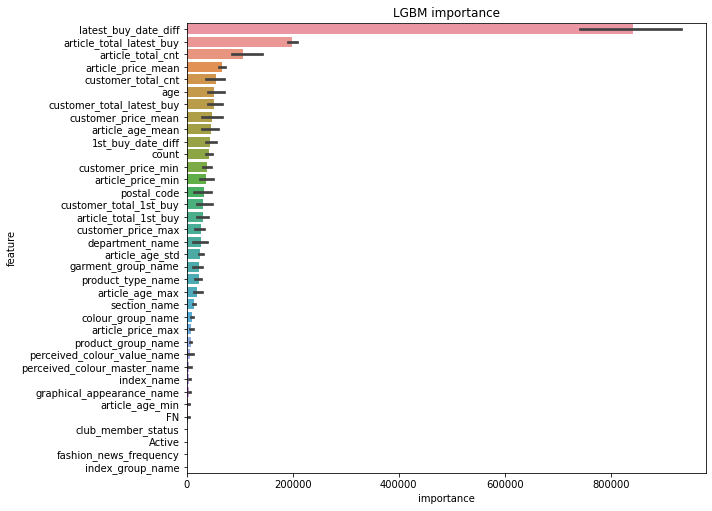

In [17]:
fi_n = fi['feature'].nunique()
order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, fi_n*0.2))
sns.barplot(x="importance", y="feature", data=fi, order=order)
plt.title(f"LGBM importance")
plt.tight_layout()
plt.savefig(OUTPUT_DIR + f'{exp_name}/lgbm_importance.png')

# sub

In [18]:
# 2値分類の出力を元に12個選定
test = ml_test[['customer_id', 'article_id']].copy()
test['prob'] = test_pred
test = test.sort_values(['customer_id', 'prob'], ascending=False)
test = test.groupby('customer_id').head(12)
test = test.groupby('customer_id')['article_id'].apply(list).reset_index()

In [19]:
sub = sample['customer_id'].to_frame()
sub = sub.merge(test, on=['customer_id'], how='left')
sub = sub.rename(columns={'article_id':'prediction'})
assert(sub['prediction'].apply(len).min()==12)
sub['prediction'] = sub['prediction'].apply(lambda x: ' '.join(x))
sub.to_csv(OUTPUT_DIR + f'{exp_name}/{exp_name}_sub.csv', index=False)
sub.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0924243001 0568601006 0915529005 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0351484002 0918292001 0723529001 0915529003 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0924243001 0915529005 0915526001 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0924243001 0751471043 0751471001 0915529005 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0924243001 0730683050 0896152002 0751471043 09...


In [20]:
message = f'{exp_name} is finished!\nvalid_score : {cv_score}'
line_notify.send(message)